In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import lightgbm as lgb
from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

# Задача 1:
* Проведите аналитику полученных данных
* Подготовьте данные для регрессионной модели
* Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES
* Оцените качество модели с помощью функции metric

In [3]:
df = pd.read_csv('data_regression_for_task.csv')

* YEAR: год продажи
* MONTH: месяц продажи
* CONTRAGENT: поставщик товарной позиции
* ARTICLE_CODE: код товарной позиции
* ARTICLE_NAME: название товарной позиции
* ARTICLE_GROUP: название группы товарных позиций
* SALES: продажи товарной позиции в этот месяц и год (целевая переменная)
* STORE_SALES: продажи всего магазина

In [4]:
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


Есть пропуски в CONTRAGENT и ARTICLE_GROUP. Посмотрим на них подробнее.

In [6]:
df['CONTRAGENT'].nunique()

333

In [7]:
df[df['CONTRAGENT'].isna()].head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
19483,2017,6,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-9.0
20056,2017,8,NaN,1279,EMPTY WINE KEG - KEGS,DUNNAGE,0.0,-5.0
32282,2017,6,NaN,BC,BEER CREDIT,REF,0.0,-58.0
32283,2017,6,NaN,WC,WINE CREDIT,REF,0.0,-8.0
45871,2017,8,NaN,BC,BEER CREDIT,REF,0.0,-699.0


In [8]:
# Пропуски случайные, заполним спец значением
df.loc[df['CONTRAGENT'].isna(),'CONTRAGENT'] = 'unknown'

In [9]:
df['ARTICLE_GROUP'].nunique(), df['ARTICLE_GROUP'].unique()

(8,
 array(['WINE', 'LIQUOR', 'BEER', 'STR_SUPPLIES', 'REF', 'NON-ALCOHOL',
        'KEGS', 'DUNNAGE', nan], dtype=object))

In [10]:
df[df['ARTICLE_GROUP'].isna()]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
66439,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,347939,FONTANAFREDDA BAROLO SILVER LABEL 750 ML,NaN,0.0,1.0


In [11]:
# FONTANAFREDDA BAROLO SILVER LABEL это вино. Значит ARTICLE_GROUP этого товара - WINE
df.loc[df['ARTICLE_GROUP'].isna(), 'ARTICLE_GROUP'] = 'WINE'

In [12]:
# пропусков в данных больше нет
df.isna().sum()

YEAR             0
MONTH            0
CONTRAGENT       0
ARTICLE_CODE     0
ARTICLE_NAME     0
ARTICLE_GROUP    0
SALES            0
STORE_SALES      0
dtype: int64

Посмотрим на переменные подробнее

* 'YEAR', 'MONTH'

In [13]:
df['YEAR'].unique(), df['MONTH'].unique()

(array([2017, 2018], dtype=int64),
 array([ 4,  5, 10, 12,  2,  6,  8,  9, 11,  1], dtype=int64))

In [23]:
sorted(df[df['YEAR'] == 2017]['MONTH'].unique()) # начало с 4 месяца, пропущен 7й месяц

[4, 5, 6, 8, 9, 10, 11, 12]

In [24]:
sorted(df[df['YEAR'] == 2018]['MONTH'].unique()) # только первые два месяца

[1, 2]

Данные представлены за 2 года, но не по всем месяцам

* 'CONTRAGENT'

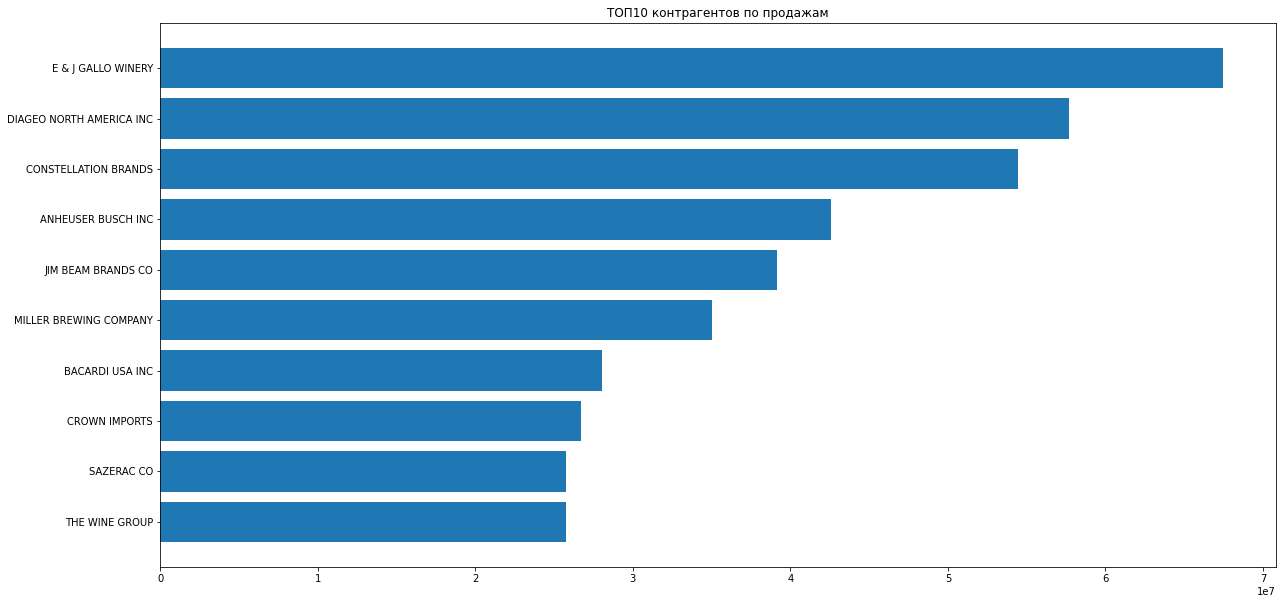

In [25]:
a = df.groupby('CONTRAGENT')['SALES'].sum().sort_values()
b = a.tail(10)
plt.barh(b.index, b.values)
plt.title('ТОП10 контрагентов по продажам');

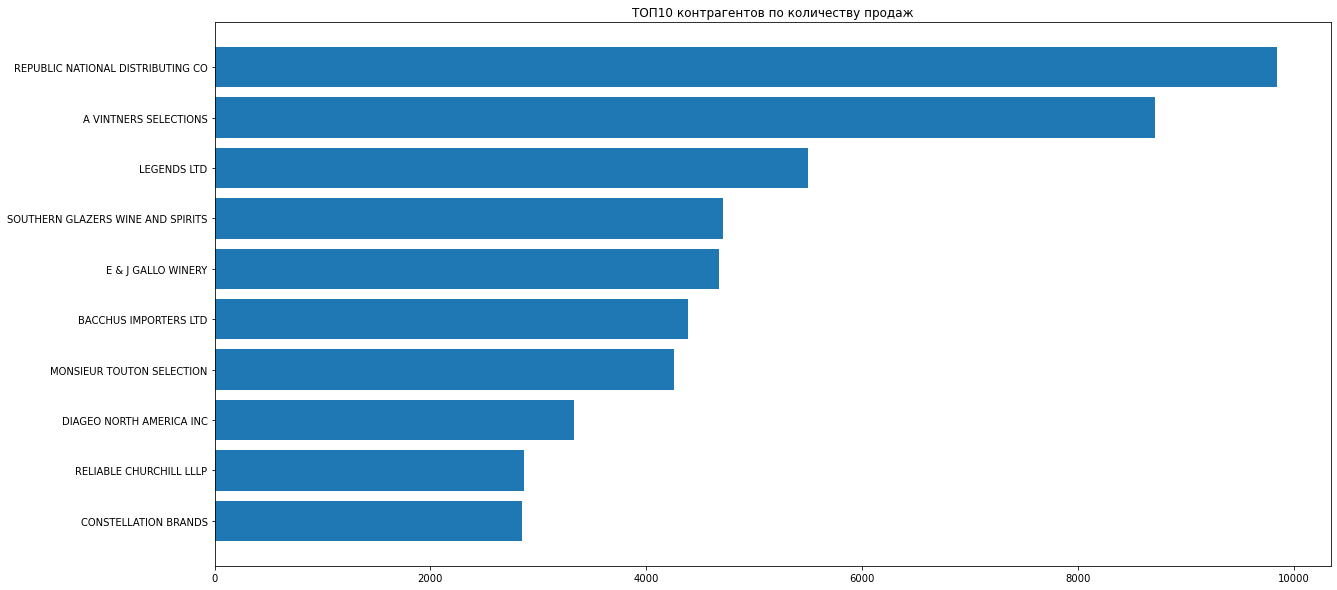

In [26]:
c = df.groupby('CONTRAGENT')['SALES'].count().sort_values()
b = c.tail(10)
plt.barh(b.index, b.values)
plt.title('ТОП10 контрагентов по количеству продаж');

Есть контрагенты, которые работают на разовый объем продаж, а есть те, кто продает как можно чаще, но не такими большими объемами - и это разные агенты

In [27]:
print(f'{a[a == 0].count()} контрагентов с нулевыми продажами за весь период')

18 контрагентов с нулевыми продажами за весь период


* 'ARTICLE_CODE', 'ARTICLE_NAME'

In [28]:
df['ARTICLE_CODE'].nunique(), df['ARTICLE_NAME'].nunique()

(23556, 23624)

Кодов продукции меньше, чем названий товаров, возможно из-за того, что некоторые имена товаров менялись

In [29]:
a = df.groupby('ARTICLE_CODE')['SALES'].sum().sort_values()

In [30]:
df[df['ARTICLE_CODE'].isin(a.tail().index)]['ARTICLE_NAME'].unique(), \
df[df['ARTICLE_CODE'].isin(a.tail().index)]['ARTICLE_GROUP'].unique()

(array(['CORONA EXTRA LOOSE NR - 12OZ', 'HEINEKEN LOOSE NR - 12OZ',
        "TITO'S HANDMADE VODKA - 1.75L", 'CORONA EXTRA 4/6 NR - 12OZ',
        'STELLA ARTOIS 4/6 NR - 11.2OZ'], dtype=object),
 array(['BEER', 'LIQUOR'], dtype=object))

In [31]:
df[df['ARTICLE_CODE'].isin(a[a < 0].index)]['ARTICLE_NAME'].unique(), \
df[df['ARTICLE_CODE'].isin(a[a < 0].index)]['ARTICLE_GROUP'].unique()

(array(['MASSIMO NEW ZELAND S/BLC - 750ML', 'BON APPETIT MUSCAT - 750ML',
        'ZACA MESA SYR - 750ML', 'WEREWOLF CAB - 750ML',
        'MARCHESI DI BAROLO BAROLO      31343 - 750ML'], dtype=object),
 array(['WINE'], dtype=object))

In [32]:
a[a == 0].shape[0]

11701

Лучше всего продается пиво и ликеры. Отрицательный показатель продаж (разбили до продаж?, просрочилось? - подумаю позже) у вин. У 11701 товара продажи на нуле. 

* 'ARTICLE_GROUP'

In [33]:
df['ARTICLE_GROUP'].unique() # 8 уникальных групп товаров

array(['WINE', 'LIQUOR', 'BEER', 'STR_SUPPLIES', 'REF', 'NON-ALCOHOL',
       'KEGS', 'DUNNAGE'], dtype=object)

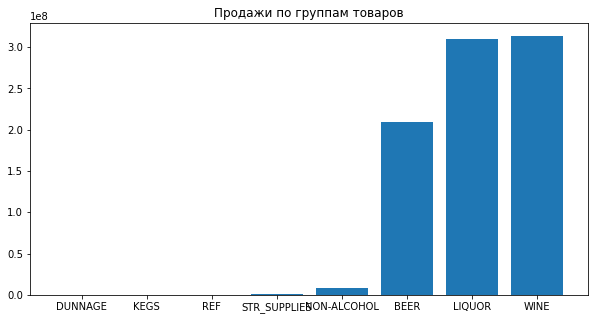

In [34]:
a = df.groupby('ARTICLE_GROUP')['SALES'].sum().sort_values()
plt.figure(figsize=(10, 5)) 
plt.bar(a.index, a.values)
plt.title('Продажи по группам товаров');

В основном продается активно вино, ликеры и пиво. dunnage и kegs имеют нулевые продажи

* 'SALES'

In [35]:
df[(df['YEAR'] == 2017) & (df['MONTH'] == 4)]['SALES'].sum()

0.0

Так как продажи (наш таргет) за этот период нулевые (возможно статистика по продажам еще не велась), то лучше удалить их из анализа, так как вряд ли реально все ничего не прдавали целый месяц

In [36]:
df = df[~((df['YEAR'] == 2017) & (df['MONTH'] == 4))]

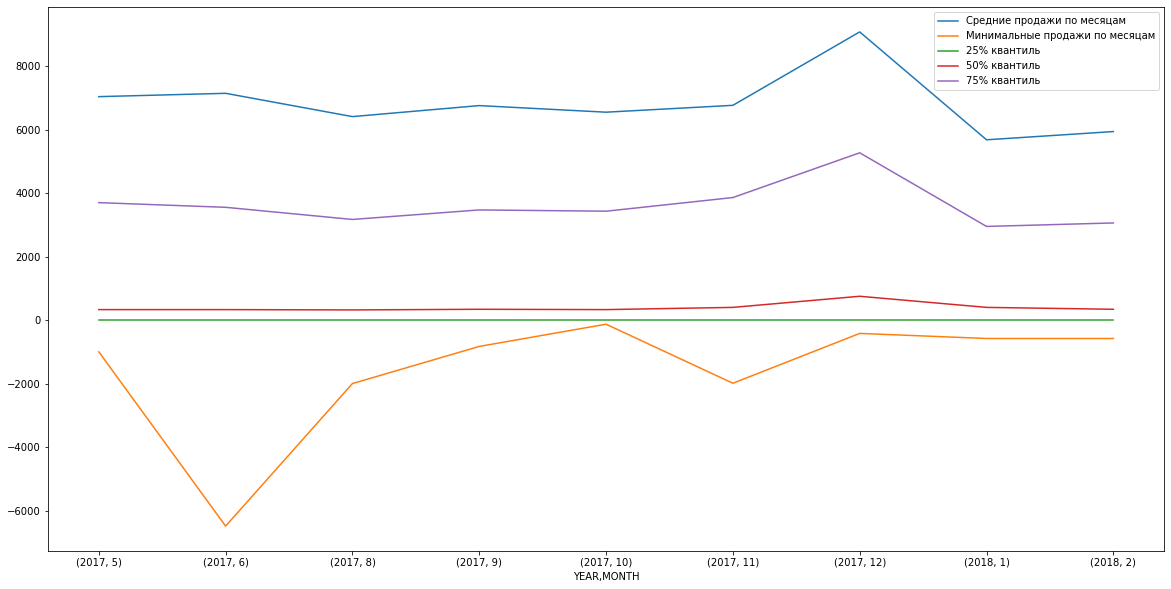

In [39]:
df.groupby(['YEAR', 'MONTH'])['SALES'].mean().plot(label='Средние продажи по месяцам')
df.groupby(['YEAR', 'MONTH'])['SALES'].min().plot(label='Минимальные продажи по месяцам')
df.groupby(['YEAR', 'MONTH'])['SALES'].quantile(0.25).plot(label='25% квантиль')
df.groupby(['YEAR', 'MONTH'])['SALES'].quantile(0.5).plot(label='50% квантиль')
df.groupby(['YEAR', 'MONTH'])['SALES'].quantile(0.75).plot(label='75% квантиль')
plt.legend();

За исключением одного пика в 12.2017 остальные средние продажи примерно на одном уровне. Отрицательные продажи сильно наблюдаются в 06.2017 и не так сильно в 11.2017 - похоже на цикл, но мало данных, чтобы это сказать точнее. Средние продажи лежат выше 75% квантиля, значит много высоких значений в продажах

In [40]:
df.sort_values(['YEAR','MONTH'], inplace=True)

In [41]:
df[df['SALES'] < 0]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
9310,2017,5,PARK STREET IMPORTS LLC,314022,TANTEO CHIPOTLE TEQUILA - 750ML,LIQUOR,-1000.0,0.0
13439,2017,5,BACCHUS IMPORTERS LTD,41740,CLEAR CREEK S/M WHISKEY - 750ML,LIQUOR,-80.0,0.0
14361,2017,5,MHW LTD,46382,BOL'S CREME DE MINT WHITE - 750ML,LIQUOR,-80.0,0.0
14388,2017,5,PRESTIGE BEVERAGE GROUP OF MD LLC,46545,CATOCTIN CREEK MOSBYS SPIRIT - 750ML,LIQUOR,-1000.0,0.0
16099,2017,5,BACCHUS IMPORTERS LTD,72334,DOM CICCIO AND FIGLI FINOCCHIETO - 750ML,LIQUOR,-170.0,0.0
16623,2017,5,CAMPARI AMERICA LLC,77280,GRAND MARNIER 1880 - 750ML,LIQUOR,-160.0,0.0
17448,2017,5,DELICATO FAMILY VINEYARDS,82797,MASSIMO NEW ZELAND S/BLC - 750ML,WINE,-80.0,0.0
22389,2017,6,REPUBLIC NATIONAL DISTRIBUTING CO,30970,BRANCOTT MARL P/NOIR - 750ML,WINE,-250.0,0.0
26916,2017,6,MHW LTD,414050,FEUDI D'ALBE MONTEPUL D'ABRU - 750ML,WINE,-770.0,15.0
27136,2017,6,JIM BEAM BRANDS CO,42412,DEKUYPER SIGN VANILLA DELIGHT - 750ML,LIQUOR,-10.0,0.0


Есть немного данных с отрицательными продажами. Это может быть, например, ошибка при транспортировке/хранении (разбили бутылку), истечение срока годности и т.д. Предполагаю, что это списанная продукция, которую уже невозможно продать. Так же возможно, что это возврат, но при условии, что алкогольные напитки разрешено возвращать, что вряд ли.

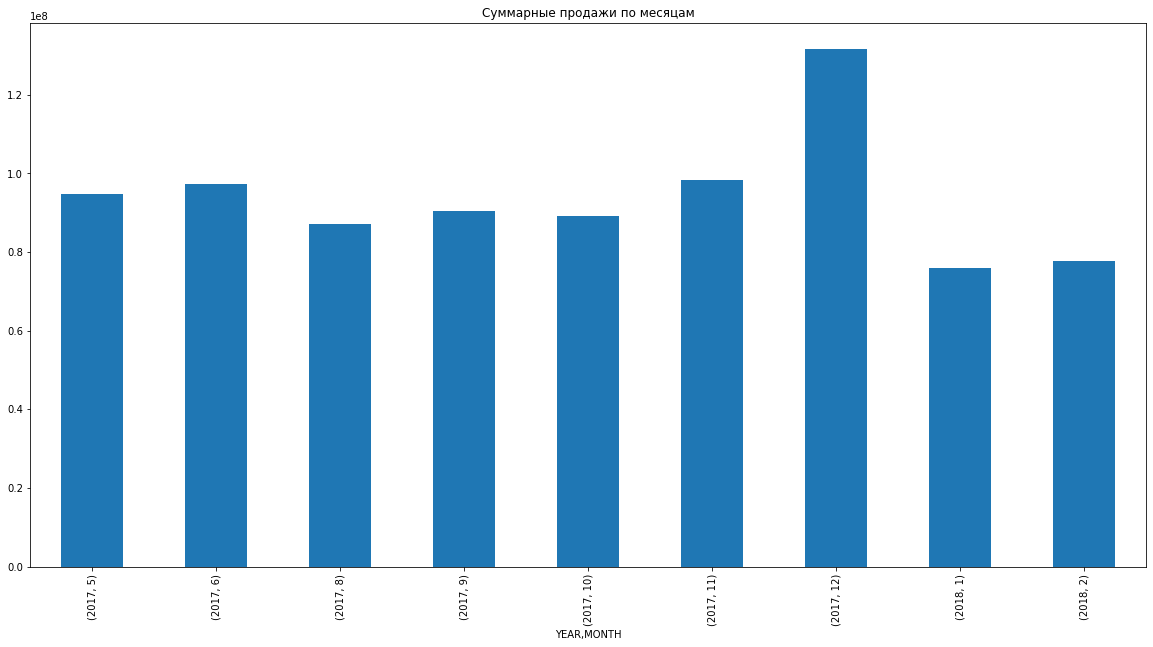

In [44]:
df.groupby(['YEAR', 'MONTH'])['SALES'].sum().plot(kind='bar',title='Суммарные продажи по месяцам');

В суммарных продажах есть пик 12.2017 и далее спад - на новый год очень большой спрос на алкоголь :)

In [45]:
df['SALES'].describe()

count    1.231600e+05
mean     6.839872e+03
std      2.949661e+04
min     -6.490000e+03
25%      0.000000e+00
50%      4.000000e+02
75%      3.600000e+03
max      1.616600e+06
Name: SALES, dtype: float64

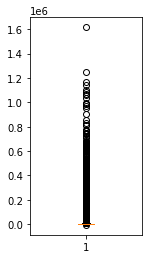

In [46]:
plt.figure(figsize=(2, 4))
plt.boxplot(df['SALES']);

Очень большой разброс значений

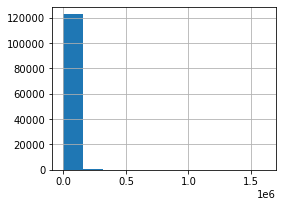

In [47]:
# распределение
plt.figure(figsize=(4, 3)) 
df['SALES'].hist();

Распределение данных не нормальное (оно похоже на Пуассоновское), надо это учесть в модели

* 'STORE_SALES'

In [48]:
# проверка не одно ли тоже это -> нет
df[['STORE_SALES','SALES']].corr()

,STORE_SALES,SALES
STORE_SALES,1.000000,0.459465
SALES,0.459465,1.000000


In [49]:
df['STORE_SALES'].describe()

count    123160.000000
mean         23.578522
std         244.650361
min       -4996.000000
25%           0.000000
50%           1.000000
75%           4.920000
max       16271.750000
Name: STORE_SALES, dtype: float64

In [50]:
df.groupby(['YEAR', 'MONTH'])['STORE_SALES'].mean()

YEAR  MONTH
2017  5        27.310548
      6        27.839069
      8        28.122641
      9        22.817909
      10       22.289367
      11       23.348862
      12       21.169463
2018  1        19.072137
      2        20.229658
Name: STORE_SALES, dtype: float64

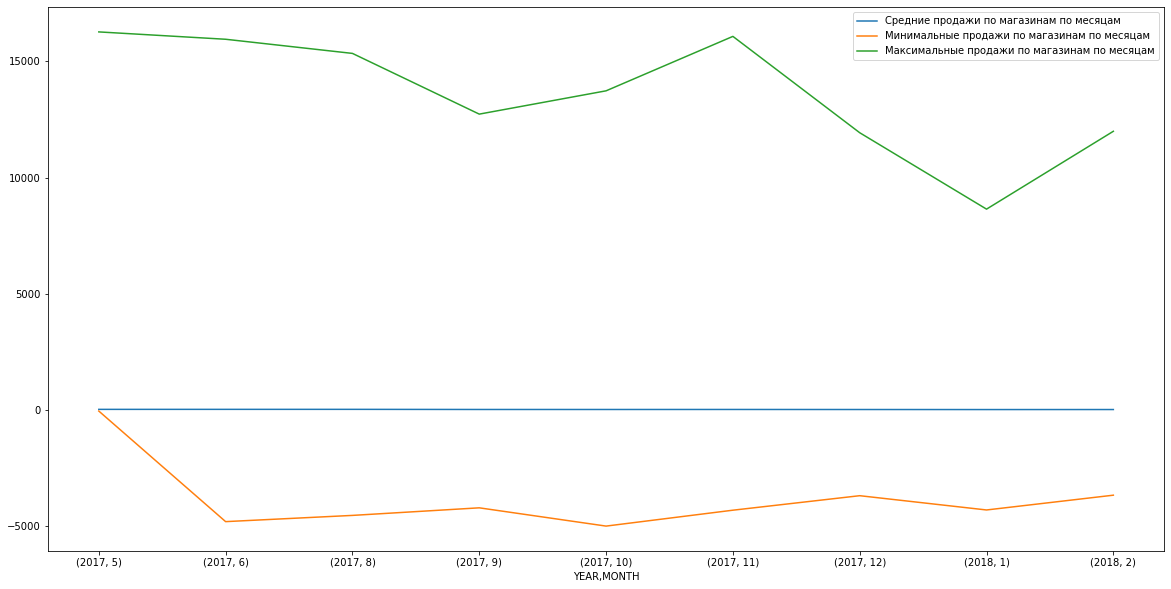

In [53]:
df.groupby(['YEAR', 'MONTH'])['STORE_SALES'].mean().plot(label='Средние продажи по магазинам по месяцам')
df.groupby(['YEAR', 'MONTH'])['STORE_SALES'].min().plot(label='Минимальные продажи по магазинам по месяцам')
df.groupby(['YEAR', 'MONTH'])['STORE_SALES'].max().plot(label='Максимальные продажи по магазинам по месяцам')
#plt.yscale('log')
plt.legend();

Средние продажи по магазинам маленькие, в то время как макстималбные и минимальные выделяются сильно, т.е. очень высокая дисперсия в данных 

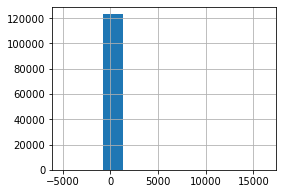

In [54]:
# распределение
plt.figure(figsize=(4, 3)) 
df['STORE_SALES'].hist();

Распределение данных аналогично предыдущему не нормальное

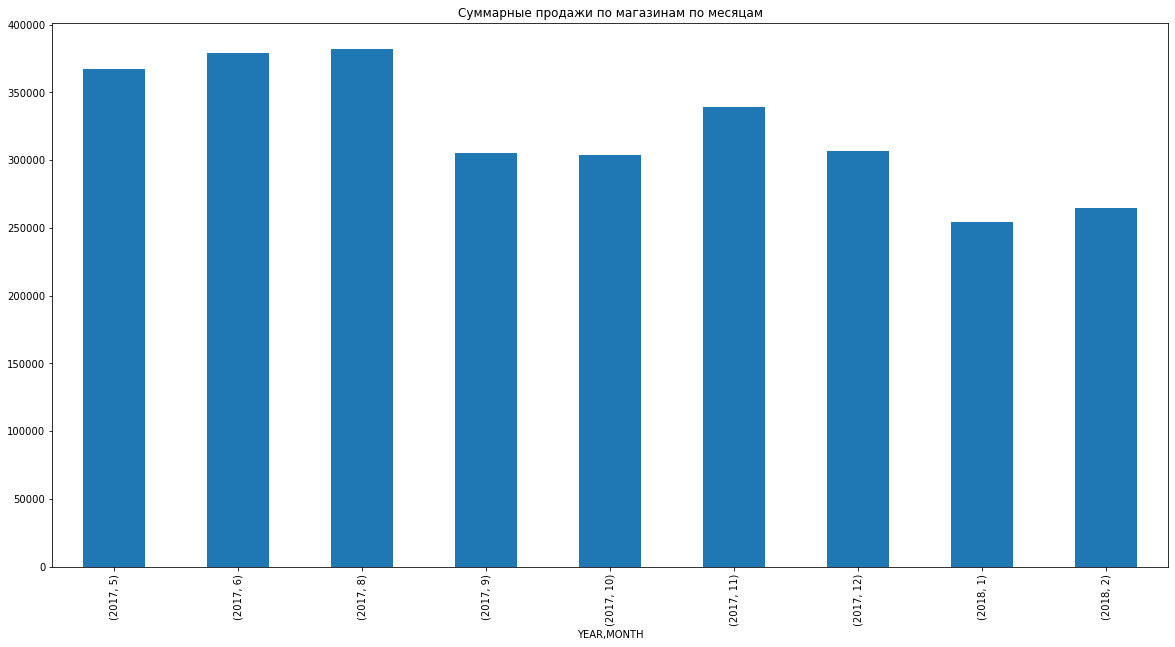

In [55]:
df.groupby(['YEAR', 'MONTH'])['STORE_SALES'].sum().plot(kind='bar',title='Суммарные продажи по магазинам по месяцам');

По суммарным продажам по магазинам картина отличная от продаж по товарам. Новый год у них не самый удачный, да и в принципе продажи идут на спад

### Model

In [56]:
test = df[(df['YEAR'] == 2018) & (df['MONTH'] == 2)].copy()
y_test = test['SALES']
X_test = test.drop(['SALES'], axis=1)

df_new = df[~((df['YEAR'] == 2018) & (df['MONTH'] == 2))] #wo test
val = df[(df['YEAR'] == 2018) & (df['MONTH'] == 1)]
y_val = val['SALES']
X_val = val.drop(['SALES'], axis=1)

train = df_new[~((df_new['YEAR'] == 2018) & (df_new['MONTH'] == 1))]
y_train = train['SALES']
X_train = train.drop(['SALES'], axis=1)

Попробуем простую модель: последнее значение по группе товара + среднее изменение

In [57]:
mean_sales = df_new.groupby(['YEAR','MONTH','ARTICLE_CODE'])['SALES'].mean()
diff_mean_sales = mean_sales.groupby('ARTICLE_CODE').diff()
delta = diff_mean_sales.groupby('ARTICLE_CODE').mean()

In [58]:
mean_sales = pd.DataFrame(mean_sales)
mean_sales.reset_index(inplace=True)
total = mean_sales[(mean_sales['YEAR'] == 2018)].merge(delta, on=['ARTICLE_CODE'], suffixes=('','_delta'))
total['SALES_new'] = total['SALES'] + total['SALES_delta']

In [59]:
test_pred = X_test[['ARTICLE_CODE']].merge(total[['ARTICLE_CODE','SALES_new']], how='left', on='ARTICLE_CODE')

In [60]:
# для товаров, которых не было в трейне предскажим аналогично, но по категориям:
mean_sales = df_new.groupby(['YEAR','MONTH','ARTICLE_GROUP'])['SALES'].mean()
diff_mean_sales = mean_sales.groupby('ARTICLE_GROUP').diff()
delta = diff_mean_sales.groupby('ARTICLE_GROUP').mean()

mean_sales = pd.DataFrame(mean_sales)
mean_sales.reset_index(inplace=True)
total = mean_sales[(mean_sales['YEAR'] == 2018)].merge(delta, on=['ARTICLE_GROUP'], suffixes=('','_delta'))
total['SALES_new'] = total['SALES'] + total['SALES_delta']

In [61]:
nan_index = test_pred.loc[test_pred['SALES_new'].isna()].index
test_pred.loc[test_pred['SALES_new'].isna(), 'SALES_new'] = \
    X_test[['ARTICLE_GROUP']].merge(total[['ARTICLE_GROUP','SALES_new']], 
                                    how='left', on='ARTICLE_GROUP').loc[nan_index,'SALES_new']

In [62]:
test_pred = test_pred['SALES_new']

In [63]:
# посчитаем метрику
metric(y_test.values, test_pred.values)

54.19740477217869

Теперь попробуем сделать модель посильнее

In [76]:
cat_cols = ['CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME', 'ARTICLE_GROUP']

In [77]:
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train[cat_cols], y_train)
X_val_encoded = te.transform(X_val[cat_cols])

X_train = X_train[['YEAR', 'MONTH', 'STORE_SALES']].join(X_target_encoded)
X_val = X_val[['YEAR', 'MONTH', 'STORE_SALES']].join(X_val_encoded)

In [78]:
# define random hyperparammeters
params = {
    'boosting_type': 'gbdt',
    'metric': 'mape',
    'objective': 'regression', 
    'n_jobs': -1,
    'seed': 0,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75}

train_set = lgb.Dataset(X_train, y_train)
val_set = lgb.Dataset(X_val, y_val)

In [79]:
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 96715, number of used features: 6
[LightGBM] [Info] Start training from score 7121.984904
Training until validation scores don't improve for 50 rounds
[100]	training's mape: 112.434	valid_1's mape: 112.02
[200]	training's mape: 91.7469	valid_1's mape: 90.6267
Early stopping, best iteration is:
[166]	training's mape: 91.8221	valid_1's mape: 88.3579


In [80]:
# собираем вместе
df_new_target_encoded = te.fit_transform(df_new[cat_cols], df_new['SALES'])
test_encoded = te.transform(X_test[cat_cols])

df_new = df_new[['YEAR', 'MONTH', 'STORE_SALES']].join(df_new_target_encoded)
test = test[['YEAR', 'MONTH', 'STORE_SALES']].join(test_encoded)

In [81]:
test_pred = model.predict(test)

In [82]:
metric(y_test.values, test_pred)

38.639957047793814

Качество стало лучше благодаря кодировке категориальных переменных и использованию lgb модели.

Попробуем ту же модель, но с учетом ненормального распределения данных

In [83]:
test = df[(df['YEAR'] == 2018) & (df['MONTH'] == 2)].copy()
y_test = test['SALES']
X_test = test.drop(['SALES'], axis=1)

df_new = df[~((df['YEAR'] == 2018) & (df['MONTH'] == 2))] #wo test
val = df[(df['YEAR'] == 2018) & (df['MONTH'] == 1)]
y_val = val['SALES']
X_val = val.drop(['SALES'], axis=1)

train = df_new[~((df_new['YEAR'] == 2018) & (df_new['MONTH'] == 1))]
y_train = train['SALES']
X_train = train.drop(['SALES'], axis=1)

In [84]:
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train[cat_cols], y_train)
X_val_encoded = te.transform(X_val[cat_cols])

X_train = X_train[['YEAR', 'MONTH', 'STORE_SALES']].join(X_target_encoded)
X_val = X_val[['YEAR', 'MONTH', 'STORE_SALES']].join(X_val_encoded)

In [85]:
const = np.abs(y_train.min())

In [86]:
# define random hyperparammeters
params = {
    'boosting_type': 'gbdt',
    'metric': 'mape',
    'objective': 'tweedie', ###
    'n_jobs': -1,
    'seed': 0,
    'learning_rate': 0.15,
    'bagging_fraction': 0.8,
    'bagging_freq': 5, 
    'colsample_bytree': 0.75
}

train_set = lgb.Dataset(X_train, y_train+const)
val_set = lgb.Dataset(X_val, y_val+const)

In [87]:
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 96715, number of used features: 6
[LightGBM] [Info] Start training from score 9.518706
Training until validation scores don't improve for 50 rounds
[100]	training's mape: 0.166295	valid_1's mape: 0.13834
Early stopping, best iteration is:
[89]	training's mape: 0.166619	valid_1's mape: 0.137709


In [88]:
# собираем вместе
df_new_target_encoded = te.fit_transform(df_new[cat_cols], df_new['SALES'])
test_encoded = te.transform(X_test[cat_cols])

df_new = df_new[['YEAR', 'MONTH', 'STORE_SALES']].join(df_new_target_encoded)
test = test[['YEAR', 'MONTH', 'STORE_SALES']].join(test_encoded)

In [89]:
test_pred = model.predict(test)

In [90]:
metric(y_test.values, test_pred - const)

38.67922916239318

Получилось то же качество, что и ранее